# Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

Bu hücrede gerekli kütüphaneleri yükledin ve uyarıları kapattın. Veri işleme, görselleştirme ve modelleme için temel araçlar artık hazır.

In [ ]:
train = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/train_V2.csv')
train = train.dropna(subset=['winPlacePerc'])

print(train.shape)
train.head()

(4446965, 29)


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


Bu hücrede veri setini yükledim ve hedef değişkeni (`winPlacePerc`) boş olan satırları sildim.

In [3]:
# Toplam mesafe
train['totalDistance'] = (
    train['walkDistance'] +
    train['rideDistance'] +
    train['swimDistance']
)

# Yürüme & Sürüş oranı
train['walkRideRatio'] = train['walkDistance'] / (train['rideDistance'] + 1)

# Savaş yoğunluğu
train['damagePerKill'] = train['damageDealt'] / (train['kills'] + 1)

Bu hücrede yeni feature’lar ekledim:

* `totalDistance`: yürüyüş, sürüş ve yüzme mesafelerini topladım, oyuncunun toplam hareketini gösteriyor.
* `walkRideRatio`: yürüyüşün sürüşe oranını aldım, oyuncunun oyun tarzını anlamaya yardımcı.
* `damagePerKill`: hasar/öldürme oranını hesapladım, savaş etkinliğini ölçüyor.

In [ ]:
# Oyuncunun grup içindeki kişi sayısı
train['playersInGroup'] = train.groupby('groupId')['Id'].transform('count')

# Ortalama takım yeteneği
train['teamKillsRatio'] = train['teamKills'] / (train['kills'] + 1)

# Her maçta toplam oyuncu sayısı
train['playersInMatch'] = train.groupby('matchId')['Id'].transform('count')

Bu hücrede grup ve maç bazlı feature’lar ekledim:

* `playersInGroup`: her oyuncunun grubundaki kişi sayısını buldum, takım büyüklüğünü gösteriyor.
* `teamKillsRatio`: takım öldürme sayısının oyuncu öldürmesine oranı, takım katkısını ölçüyor.
* `playersInMatch`: maçtaki toplam oyuncu sayısı, maç büyüklüğünü temsil ediyor.

In [5]:
# Kill + damage skor
train['combatScore'] = train['kills'] * 0.7 + train['damageDealt'] * 0.3

# Hareket + savaş birleşik skor
train['playerAggression'] = (
    train['walkDistance'] * 0.5 +
    train['kills'] * 1.5 +
    train['damageDealt'] * 0.3
)

Bu hücrede oyuncu performansını özetleyen yeni feature’lar ekledim:

* `combatScore`: öldürme ve verilen hasarın ağırlıklı birleşimi, oyuncunun savaş etkinliğini gösteriyor.
* `playerAggression`: yürüyüş mesafesi, öldürme ve hasarı birleştirerek oyuncunun agresifliğini ölçen bir skor oluşturdum.

In [6]:
num_features = [
    'kills','damageDealt','walkDistance','rideDistance','weaponsAcquired',
    'totalDistance','walkRideRatio','damagePerKill','playersInGroup',
    'playersInMatch','combatScore','playerAggression'
]

cat_features = ['matchType']

X = train[num_features + cat_features]
y = train['winPlacePerc']

Bu hücrede model için kullanacağım feature’ları belirledim:

* Sayısal feature’lar: hem orijinal hem de yeni türettiğimiz skorlar ve oranlar (`num_features`).
* Kategorik feature: `matchType`.

Ardından `X` ve `y` değişkenlerini oluşturup modeli eğitmek için hazır hale getirdim.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_val.shape

((3557572, 13), (889393, 13))

Bu hücrede veriyi eğitim ve doğrulama setlerine böldüm:

* `%80` eğitim, `%20` doğrulama olarak ayırdım.
* `random_state=42` ile her çalıştırmada aynı bölünmenin olmasını sağladım.
* Artık `X_train`, `y_train` ile modeli eğitebilir, `X_val`, `y_val` ile performansını ölçebilirim.

In [8]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

Bu hücrede veri ön işleme adımlarını hazırladım:

* Sayısal değişkenler için eksik değerleri medyan ile doldurup standardize ettim.
* Kategorik değişkenler için en sık değeri doldurup one-hot encoding yaptım.
* `ColumnTransformer` ile bu iki işlemi tek pipeline içinde birleştirdim.

In [9]:
from sklearn.linear_model import LinearRegression

model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

RMSE: 0.1573
R2: 0.7377


Burada modelimizi kurup eğittim:

* `Pipeline` ile hem ön işleme hem Linear Regression modelini birleştirdim.
* Eğitimden sonra doğrulama setiyle tahmin yaptım.
* RMSE ve R² skorlarını hesaplayarak modelin performansını hızlıca gördüm.

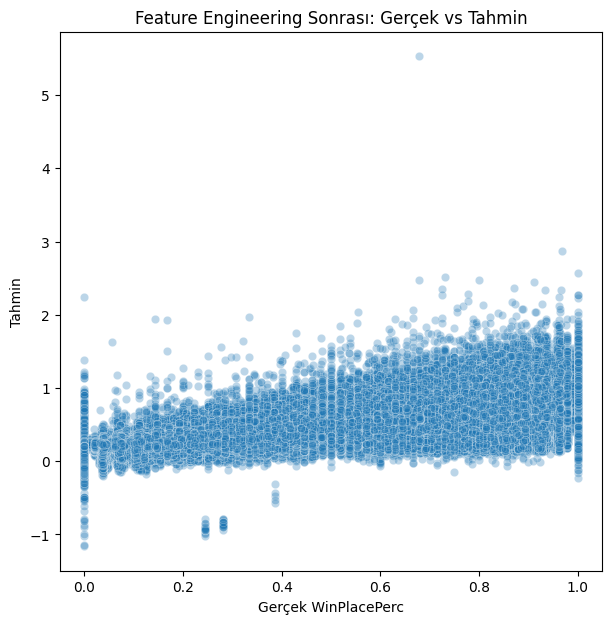

In [10]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_val, y=y_pred, alpha=0.3)
plt.title("Feature Engineering Sonrası: Gerçek vs Tahmin")
plt.xlabel("Gerçek WinPlacePerc")
plt.ylabel("Tahmin")
plt.show()

Burada Feature Engineering sonrası tahminleri görselleştirdim, noktaların 45° çizgiye yakınlığı modelin doğruluğunu gösteriyor.

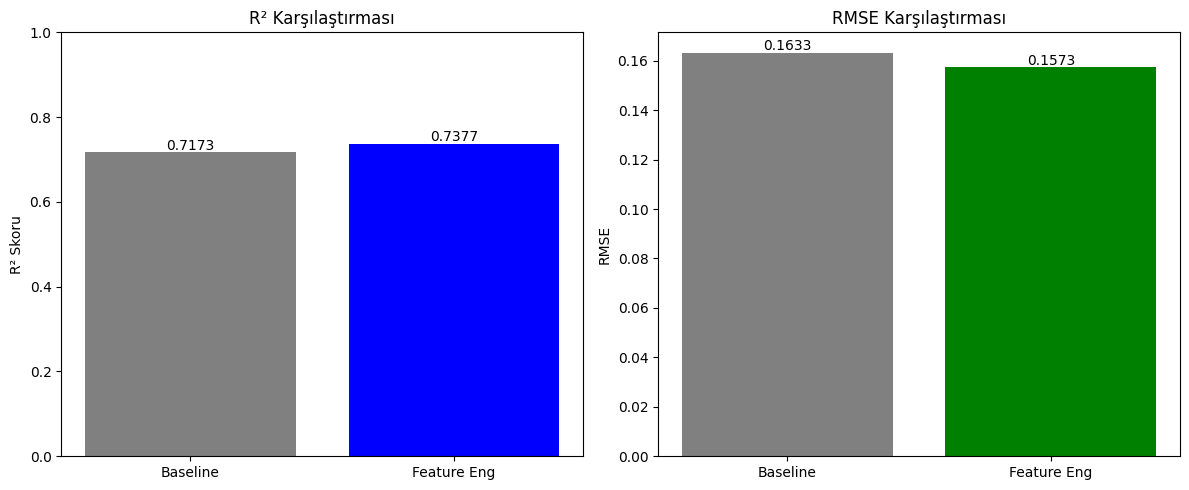

In [11]:
import matplotlib.pyplot as plt

# Skorlar
baseline_r2 = 0.7173
fe_r2 = r2  # Feature engineering modelinin R²'si
baseline_rmse = 0.1633
fe_rmse = rmse  # Feature engineering modelinin RMSE'si

# Tek figürde iki subplot
plt.figure(figsize=(12,5))

# R² Karşılaştırması
plt.subplot(1, 2, 1)
plt.bar(['Baseline', 'Feature Eng'], [baseline_r2, fe_r2], color=['gray', 'blue'])
plt.ylabel("R² Skoru")
plt.title("R² Karşılaştırması")
for i, v in enumerate([baseline_r2, fe_r2]):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center')
plt.ylim(0, 1)

# RMSE Karşılaştırması
plt.subplot(1, 2, 2)
plt.bar(['Baseline', 'Feature Eng'], [baseline_rmse, fe_rmse], color=['gray', 'green'])
plt.ylabel("RMSE")
plt.title("RMSE Karşılaştırması")
for i, v in enumerate([baseline_rmse, fe_rmse]):
    plt.text(i, v + 0.001, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

Grafikten görüldüğü gibi, feature engineering sonrası model hem **R²** (0.7377 vs 0.7173) hem de **RMSE** (0.1573 vs 0.1633) açısından baseline modelden daha iyi performans gösteriyor. Soldaki bar R²’yi, sağdaki bar RMSE’yi gösteriyor ve küçük etiketlerle sayısal değerler eklenmiş. Yani eklenen feature’lar modelin tahmin doğruluğunu ve veri açıklayıcılığını artırmış. Bu şekilde tek grafikte iki modelin performans farkını hızlıca görebiliyoruz.